In [3]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
train_df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")

In [6]:
print(train_df.describe())
print(train_df.isnull().sum())
train_df.head()

             target
count  1.306122e+06
mean   6.187018e-02
std    2.409197e-01
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000000e+00
qid              0
question_text    0
target           0
dtype: int64


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
!ls /kaggle/input/quora-insincere-questions-classification

embeddings.zip	sample_submission.csv  test.csv  train.csv


In [15]:
import zipfile

zip_file_name = '/kaggle/input/quora-insincere-questions-classification/embeddings.zip'

try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"All contents of '{zip_file_name}' extracted to the current directory.")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

All contents of '/kaggle/input/quora-insincere-questions-classification/embeddings.zip' extracted to the current directory.


In [16]:
embeddings_index = {}
f = open('/kaggle/working/glove.840B.300d/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

2196017it [02:08, 17088.49it/s]


In [17]:
embeddings_index["hello"].shape

(300,)

total:1306122 0:1225312 1:80810


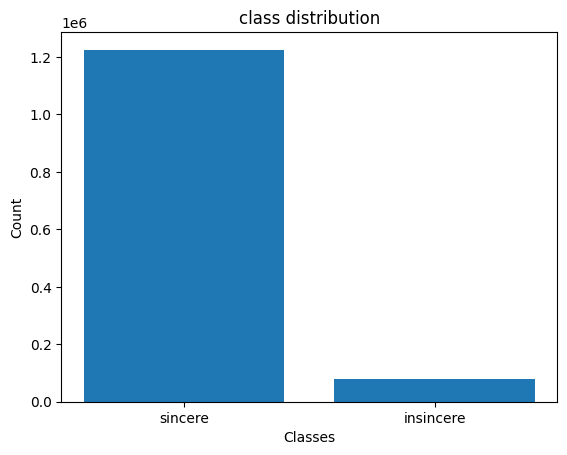

In [13]:
sincere_count = len(train_df[train_df['target'] == 0])
insincere_count = len(train_df[train_df['target'] == 1])
count = [sincere_count, insincere_count]
print(f'total:{len(train_df)} 0:{sincere_count} 1:{insincere_count}')
plt.bar(["sincere" , "insincere"], [sincere_count, insincere_count])
plt.title("class distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [18]:
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [19]:
print(1.0/torch.tensor(count).float())

tensor([8.1612e-07, 1.2375e-05])


In [20]:
maxlen = 72 # max number of words in a question to use

In [21]:
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset

class QuestionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        if 'target' not in self.df.columns:
            self.df['target'] = 0
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        empyt_emb = np.zeros(300)
        embeddings = [embeddings_index.get(w,empyt_emb) for w in row['question_text'][:-1].split(" ")]
        while len(embeddings) < maxlen:
            embeddings.append(empyt_emb)
        word_embedding = torch.tensor(embeddings)
        return word_embedding, torch.tensor(row['target']),  row['question_text']

train_df = train_df.sample(frac=1.)
train_df, val_df = train_test_split(train_df, test_size=0.2)
label_count = torch.tensor([len(train_df[train_df['target'] == 0]), len(train_df[train_df['target'] == 1]) ])
sampler = WeightedRandomSampler(1.0/label_count.float(), len(label_count))

In [24]:
train_dataset_1 = QuestionDataset(train_df)
train_dataset_1[0][0].shape

torch.Size([72, 300])

In [25]:
train_label_count = torch.tensor([len(train_df[train_df['target'] == 0]), len(train_df[train_df['target'] == 1]) ])
test_label_count = torch.tensor([len(val_df[val_df['target'] == 0]), len(val_df[val_df['target'] == 1]) ])

In [26]:
print(train_label_count)
print(test_label_count)

tensor([980227,  64670])
tensor([245085,  16140])


In [27]:
import torch.nn as nn
import math

class LstmCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        # weights with x
        # 4 -> update, forget, out, pot_next_candidate
        self.wx = nn.Linear(in_dim, 4*out_dim , bias = True)
        # weights with a(t-1)
        self.wa = nn.Linear(out_dim, 4*out_dim , bias = True)

        # Initialize parameters for better performance
        self.reset_parameters()

    def reset_parameters(self):
        # A common way to initialize weights, similar to what nn.Linear does
        stdv = 1.0 / math.sqrt(self.out_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
        
    def forward(self, x_t, c_tminus1, a_tminus1):
        gates = self.wx(x_t) + self.wa(a_tminus1)
        update_gate, forget_gate, output_gate, cell_candidate = torch.chunk(gates, chunks=4, dim=-1)
        update_gate = torch.sigmoid(update_gate)
        forget_gate = torch.sigmoid(forget_gate)
        output_gate = torch.sigmoid(output_gate)
        potential_c_t = torch.tanh(cell_candidate)
        c_t = (update_gate * potential_c_t) + (forget_gate * c_tminus1)
        a_t = output_gate * torch.tanh(c_t)
        return c_t, a_t
    

In [28]:
class Lstm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.lstm_cell = LstmCell(in_dim, out_dim)
        
    def forward(self, X):
        B,T,C = X.shape
        activations = []
        c_tminus1 = torch.zeros((B, 1, self.out_dim)).to("cuda" if torch.cuda.is_available() else "cpu")

        for i in range(T):
            a_tminus1 = activations[i-1] if i > 0 else torch.zeros((B, 1, self.out_dim)).to("cuda" if torch.cuda.is_available() else "cpu")
            c_t, a_t = self.lstm_cell(X[:,i:i+1,:], c_tminus1, a_tminus1)
            activations.append(a_t)
            c_tminus1 = c_t
        outputs = torch.stack(activations, dim=1).squeeze(-2)

        return c_tminus1, outputs

In [29]:
# test
model = Lstm(20, 50).to("cuda" if torch.cuda.is_available() else "cpu")
test = torch.zeros((10, 12, 20)).to("cuda" if torch.cuda.is_available() else "cpu")
o, a = model(test)
print(o.shape)
print(a.shape)

torch.Size([10, 1, 50])
torch.Size([10, 12, 50])


In [30]:
class BidiLstm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.f_lstm = Lstm(in_dim, out_dim)
        self.b_lstm = Lstm(in_dim, out_dim)

    def forward(self, X):
        f_c, f_act = self.f_lstm(X)
        x_reversed = torch.flip(X, dims=[1])
        b_c, b_act = self.b_lstm(x_reversed)
        output = torch.cat((f_act, torch.flip(b_act, dims=[1])), dim=-1)
        return output     

In [31]:
# test
model = BidiLstm(20, 50).to("cuda" if torch.cuda.is_available() else "cpu")
test = torch.zeros((10, 12, 20)).to("cuda" if torch.cuda.is_available() else "cpu")
o = model(test)
print(o.shape)

torch.Size([10, 12, 100])


In [32]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            BidiLstm(300, 300),
            nn.Linear(600, 200),
            nn.ReLU(),
        )
        self.mha = nn.MultiheadAttention(200, 10, batch_first=True)
        self.dense = nn.Linear(200, 1)
    def forward(self, X):
        block_out = self.block(X)
        attention, _ = self.mha(block_out, block_out, block_out)
        out = self.dense(attention[:, -1, :]).squeeze()
        return out

In [33]:
# test
model = Model().to("cuda" if torch.cuda.is_available() else "cpu")
test = torch.zeros((10, 12, 300)).to("cuda" if torch.cuda.is_available() else "cpu")
o = model(test)
print(o.shape)

torch.Size([10])


In [34]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH = 64
LEARNING_RATE = 3e-4
PIN_MEMORY = False
SHUFFLE = True
if DEVICE == "cuda":
    NUM_WORKERS = torch.cuda.device_count() * min(4, os.cpu_count())
else: 
    NUM_WORKERS = min(4, os.cpu_count())

In [47]:
from functools import partial

setup_dataloader = partial(DataLoader, 
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY,
                           batch_size=BATCH,
                           shuffle=SHUFFLE
                          )

In [68]:
train_dataset = QuestionDataset(train_df)
val_dataset = QuestionDataset(val_df)
test_dataset = QuestionDataset(test_df)

# train_data = setup_dataloader(dataset=train_dataset,sampler=sampler)
train_data = setup_dataloader(dataset=train_dataset)
val_data = setup_dataloader(dataset=val_dataset)
test_data = setup_dataloader(dataset=test_dataset)

In [69]:
from torch import optim, nn

model = Model().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [70]:
def train_model(epochs):
    EPOCHS = epochs

    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        
        for idx, data in enumerate(tqdm(train_data, position=0, leave=True)):
            print(data[0].shape)
            question = data[0].float().to(DEVICE)
            y = data[1].float().to(DEVICE)
            
            y_pred = model(question)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            
            train_running_loss += loss.item()
    
            loss.backward()
            optimizer.step()
    
        train_loss = train_running_loss / (idx + 1)
        
        train_losses.append(train_loss)
    
        model.eval()
        val_running_loss = 0
        
        with torch.no_grad():
            print(f'Started Eval')
            for idx, data in enumerate(tqdm(val_data, position=0, leave=True)):
                question = data[0].float().to(DEVICE)
                y = data[1].float().to(DEVICE)
    
                y_pred = model(question)
                loss = criterion(y_pred, y)
                
                val_running_loss += loss.item()
    
            val_loss = val_running_loss / (idx + 1)
        
        val_losses.append(val_loss)
    
        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print("\n")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print("-" * 30)
    
    # Saving the model
    torch.save(model.state_dict(), 'my_checkpoint.pth')
    return train_losses, val_losses

In [71]:
torch.autograd.set_detect_anomaly(True)

In [72]:
EPOCHS = 1
train_losses, val_losses = train_model(EPOCHS)

  0%|          | 0/16327 [00:00<?, ?it/s]

torch.Size([64, 72, 300])


  0%|          | 1/16327 [00:02<10:45:08,  2.37s/it]

torch.Size([64, 72, 300])


  0%|          | 2/16327 [00:03<7:54:58,  1.75s/it] 

torch.Size([64, 72, 300])


  0%|          | 3/16327 [00:04<6:55:36,  1.53s/it]

torch.Size([64, 72, 300])


  0%|          | 4/16327 [00:06<6:34:46,  1.45s/it]

torch.Size([64, 72, 300])


  0%|          | 5/16327 [00:07<6:15:45,  1.38s/it]

torch.Size([64, 72, 300])


  0%|          | 6/16327 [00:08<6:04:51,  1.34s/it]

torch.Size([64, 72, 300])


  0%|          | 7/16327 [00:10<5:58:48,  1.32s/it]

torch.Size([64, 72, 300])


  0%|          | 8/16327 [00:11<5:52:32,  1.30s/it]

torch.Size([64, 72, 300])


  0%|          | 0/1 [00:12<?, ?it/s]


KeyboardInterrupt: 